# Basic Raw File Generation
This tutorial walks through generation of GUPPI RAW data with injected sine signals in Gaussian noise.

If you have access to a GPU, it is highly recommended to install CuPy, which performs the equivalent NumPy array operations on the GPU (https://docs.cupy.dev/en/stable/install.html). This is not necessary to run raw voltage generation, but will highly accelerate the pipeline. If you do install CuPy to use the GPU, it can be useful to run `export CUDA_VISIBLE_DEVICES=0` before running this notebook to specify a single GPU to use.

In [ ]:
# !pip install cupy-cuda110

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl

import sys
sys.path.insert(0, "../../")
import setigen as stg

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [3]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

We first set some basic parameters behind the pipeline. `sample_rate` is in samples per second (Hz); `num_taps` and `num_branches` are specific to the polyphase filterbank described below. 

In [4]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

## Creating an Antenna

To set up the pipeline, we first create an `Antenna` object, to which we add noise and signal "sources". These allow us to generate samples when we need them; this is important when creating large raw voltage files, which may not fit in GPU / CPU memory in one go.

The `fch1` parameter indicates the starting reference frequency, and the `ascending` parameter is a boolean which marks whether the frequencies should increase or decrease from `fch1`. By default, we do not implement heterodyne mixing and filtering, so these parameters essentially specify the usable Nyquist band for the recorded synthetic observations, from `fch1` to `fch1 +/- sample_rate / 2`. Note that frequencies should be specified in Hz or using `astropy.units`.

In [5]:
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=2)

We can now add noise to each polarization:

In [6]:
antenna.x.add_noise(v_mean=0, 
                    v_std=1)

antenna.y.add_noise(v_mean=0, 
                    v_std=1)

Adding a basic drifting signal to each polarization:

In [7]:
antenna.x.add_signal(f_start=6002.2e6, 
                     drift_rate=-2*u.Hz/u.s, 
                     level=0.002,
                     mode='level')

antenna.y.add_signal(f_start=6002.2e6, 
                     drift_rate=-2*u.Hz/u.s, 
                     level=0.002,
                     phase=np.pi/2,
                     mode='level')

For dual polarization, the property `antenna.streams` maps to `[antenna.x, antenna.y]`. For single polarization, this is only `[antenna.x]`. This can help simplify code if one is adding identical noise or signal elements to each polarization.

## Making the backend elements
We have to create various elements in the backend, specifically the digitizer, polyphase filterbank, and requantizer. These only have a few parameters, but can help if you'd like to customize the specific values.

The `RealQuantizer` (digitizer) takes in floating point real "voltages" generated by the Antenna, and normalizes the FWHM of the real voltage distribution to the `target_fwhm` and quantizes them to `num_bits`. 

The `PolyphaseFilterbank` implements an ideal PFB with `num_taps` and `num_branches` as parameters. `num_branches` is the FFT length for the real FFT, so that there are a resultant `num_branches / 2` coarse channels possible to record. 

The `ComplexQuantizer` is very similar to the `RealQuantizer`, but handles the complex voltages that come out of the PFB step. Here, `num_bits` can be either 8 or 4; this is the final data manipulation done before saving out to file. 

Finally, the `RawVoltageBackend` is a class that pulls all these components together. The first argument is the `Antenna` object, from which we query the actual data. We can also specify which coarse channels we'd actually like to record, from `start_chan` to `start_chan + num_chans`. Parameters `block_size` (in bytes) and `blocks_per_file` customize the RAW files. Finally, `num_subblocks` is a factor by which each block is divided to make the pipeline manageable in GPU memory. The smaller this factor is, the more data is processed at once; if the factor is too small, the data arrays may exceed GPU memory. 

In [8]:
digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

## Recording synthetic data
Now that we have all the pieces of the backend created, we can now create GUPPI RAW files using `RawVoltageBackend.record()`. There are two modes to record, `num_blocks` and `obs_length`. The former allows you to specify how many data blocks to record, as defined by the RAW format, and the latter computes the number of required blocks from the desired observation length (in seconds). The `header_dict` parameter allows for overwriting existing header values / adding additional keywords. For example, TurboSETI requires the `TELESCOP` parameter to be set to "GBT" to run on certain types of RAW files, so you can overwrite this parameter using `header_dict`.

`raw_file_stem` is the path + prefix for your saved GUPPI RAW file.

In [9]:
rvb.record(raw_file_stem='example_1block',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

# rvb.record(raw_file_stem='example_obs_length',
#            obs_length=0.5, 
#            length_mode='obs_length',
#            header_dict={'HELLO': 'test_value',
#                         'TELESCOP': 'GBT'},
#            verbose=False)

Blocks: 100%|██████████| 1/1 [00:09<00:00,  9.79s/it]     


## Taking a look
If `rawspec` is installed, you can unpack the data as such:

In [10]:
!rawspec -f 1024 -t 4 -d . example_1block

working stem: example_1block
opening file: example_1block.0000.raw
opening file: example_1block.0001.raw [No such file or directory]
output product 0: 128 spectra


Using `blimpy` to open the resulting filterbank file and plotting the data:

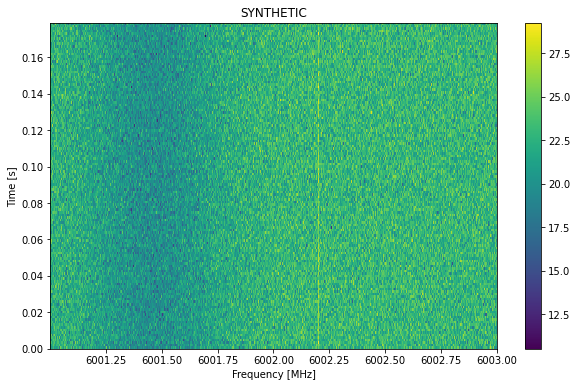

In [11]:
wf = bl.Waterfall('example_1block.rawspec.0000.fil',
                  f_start=6001.0,
                  f_stop=6003.0)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

Integrating over time:

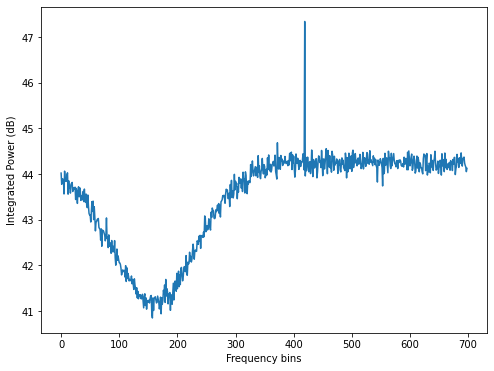

In [12]:
def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

x = db(np.sum(wf.data[:, 0, :], axis=0))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()